In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from scipy.special import roots_laguerre

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.models.model_params import LewisParams
from pricing.pricing.products.vanilla_option import VanillaOption
import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])


C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# I. Pricing via CF in the SigVol model

In [12]:
N = 6
e = ta.AlgebraBasis(dim=1, trunc=N)

### Model setup

In [3]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2)

In [4]:
rho = -0.5


model = SigVol( 
    vol_ts=0.2 * e[0] + 0.01 * e[1] + 0.1 * e[2] + 0.05 * e[11] + 0.05 * e[12] + 0.05 * e[22] + 0.01 * e[222] + 0.03 * e[221] + 0.01 * e[121] + 0.01 * e[211], 
    shuffle_table=shuffle_table,
    rho=rho)

In [5]:
print(model.vol_ts)

0.2*0 + 0.01*1 + 0.1*2 + 0.05*11 + 0.05*12 + 0.05*22 + 0.01*121 + 0.01*211 + 0.03*221 + 0.01*222


Text(0.5, 1.0, 'Vol trajectories')

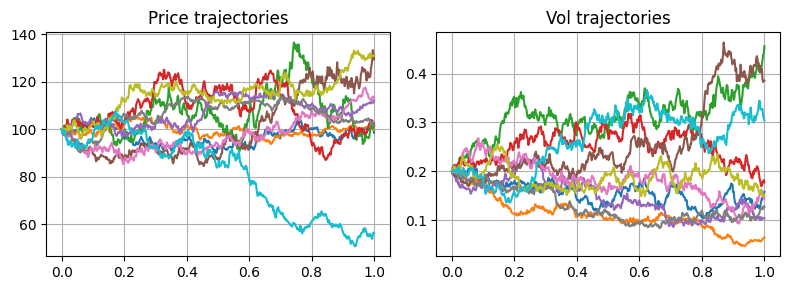

In [6]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

### Define the option 

In [7]:
T = 1
F0 = 100
K = np.array([90, 100, 110])

k = np.log(K / F0)

option = VanillaOption(T=T, K=K, flag="call")

### Pricing

In [8]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

CPU times: total: 13.5 s
Wall time: 15.2 s


In [11]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

CPU times: total: 31.2 ms
Wall time: 105 ms


[0.24359323 0.2290223  0.21821511]


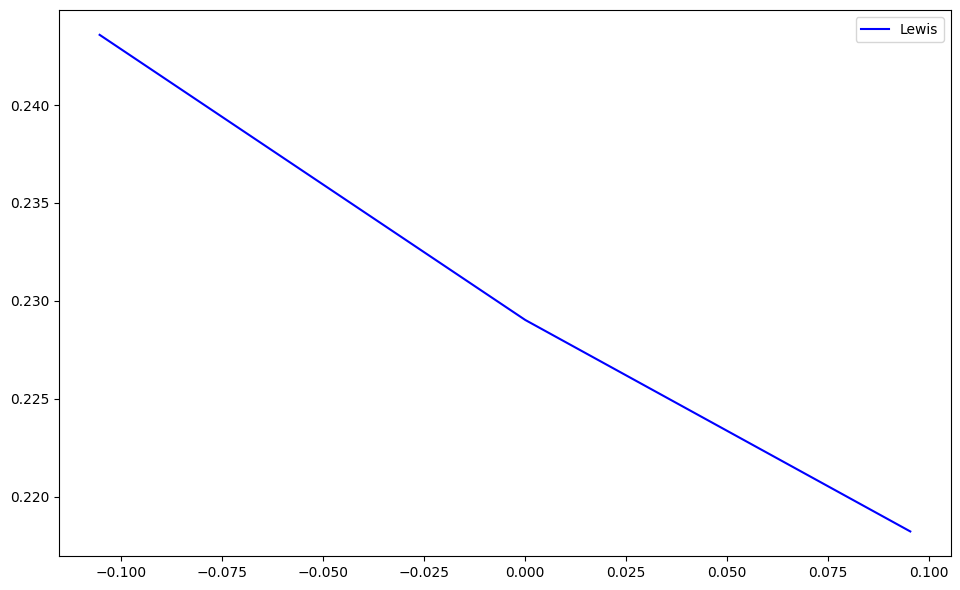

In [12]:
print(smile_cf)

fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf, "b", label="Lewis")
ax.grid()
ax.legend()

# II. Signature characteristic function

In [13]:
N = 12
dim = 2
e = ta.AlgebraBasis(dim=dim, trunc=N)

In [14]:
T = 2
u_coef = 1j # 1j
u = ta.from_word(2222, trunc=N, dim=dim) * u_coef
print(u)

1j*2222


#### Via MC

In [15]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(u_coef * W_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

((0.8403618193709563+0.15756166948719752j), 0.0005186196417914994)

#### Via quadratures

In [16]:
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * T**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]

(0.8479017389433873+0.16065596048451297j)

#### Via inf-dimensional Riccati

In [17]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)

args = {"shuffle_table": shuffle_table}

In [18]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(1) + psi.proj(22) * 0.5 + ta.shuffle_pow(psi.proj(2), 2, args["shuffle_table"]) * 0.5

In [54]:
n = 200
t_grid = np.linspace(0, T, n)

Euler : (0.8057888816197399+0.11442431795147945j)


C:\Users\DM6579\OneDrive - ENGIE\projects\signature\notebooks\../..\signature\signature\visualisation.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients[plotting_idx], "o", **kwargs)


RK4 : (0.8074371274116251+0.11042531489928979j)


C:\Users\DM6579\OneDrive - ENGIE\projects\signature\notebooks\../..\signature\signature\visualisation.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients[plotting_idx], "o", **kwargs)


PECE : (0.8072926217928362+0.11051227198585074j)


C:\Users\DM6579\OneDrive - ENGIE\projects\signature\notebooks\../..\signature\signature\visualisation.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients[plotting_idx], "o", **kwargs)


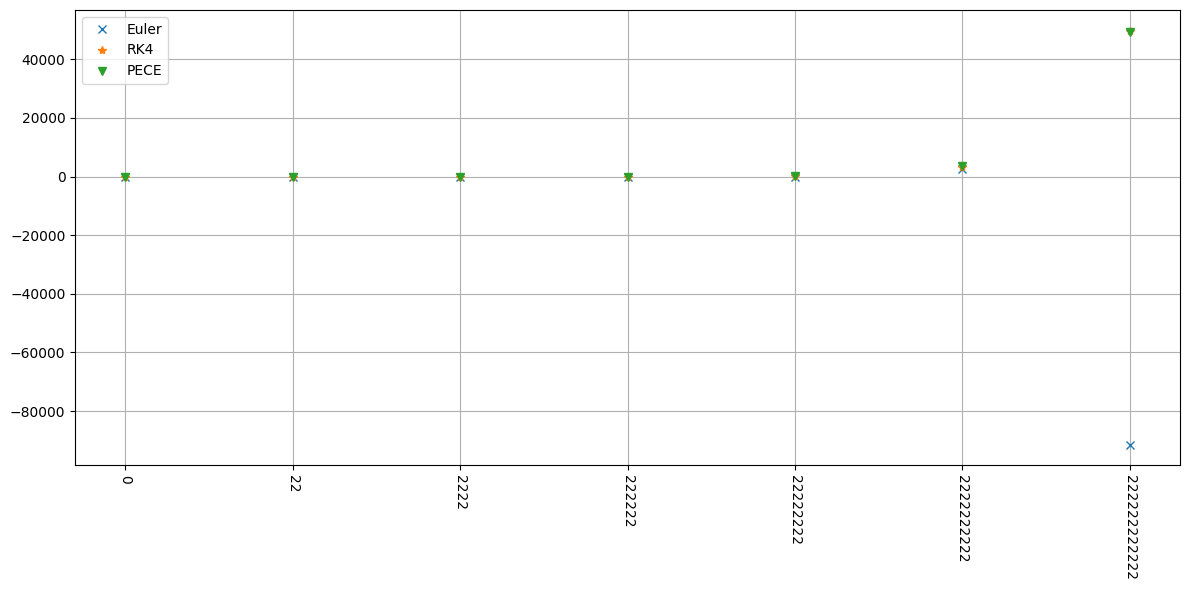

In [55]:
labels = ["Euler", "RK4", "PECE"]
markers = ["x", "*", "v"]
step_funs = [step_fun_euler, step_fun_rk4, step_fun_pece]
fig, ax = plt.subplots(figsize=(12, 6))

for label, step_fun, marker in zip(labels, step_funs, markers):
    psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u, args=args)
    psi_T = psi.subsequence([-1,])
    print(label, ":", np.exp(psi_T[0]))
    ta.plot_coefficients(psi_T, nonzero=True, ax=ax, marker=marker, label=label)

ax.legend()

### Dependence on the truncation order

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\AppData\Local\Temp\ipykernel_724\649671163.py:17: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid_trunc, np.exp(psi_pece[0]), "-", label=f"PECE, N={trunc}")
C:\Users\DM6579\An

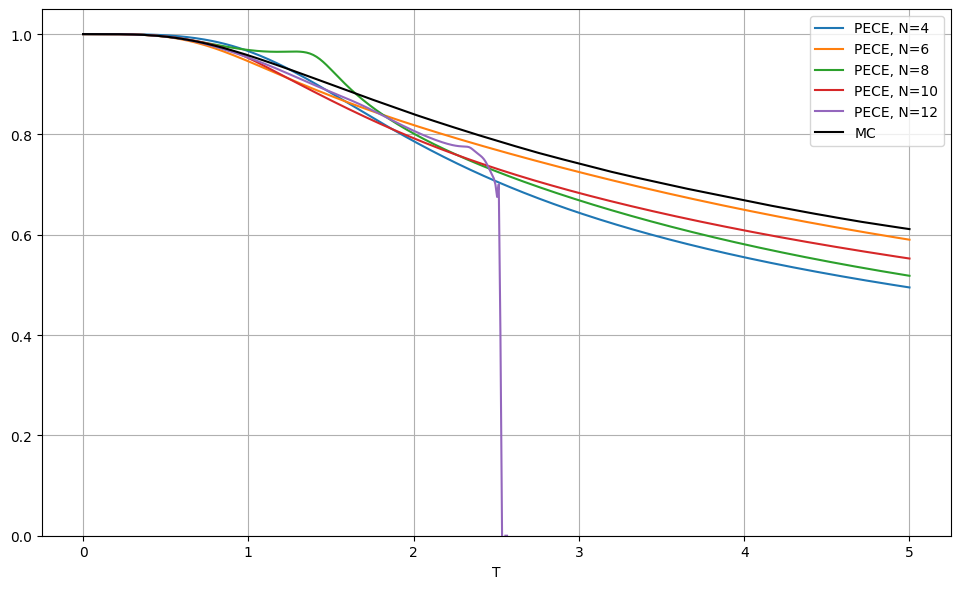

In [56]:
fig, ax = plt.subplots()

T = 5
n = 500
t_grid_trunc = np.linspace(0, T, n)

for trunc, shuffle_table_trunc in zip(truncs, shuffle_tables):
    u_trunc = ta.from_array(u.array, trunc=trunc, dim=dim)
    args_trunc = {"shuffle_table": shuffle_table_trunc}
    
    #psi_euler = ode_solver_traj(fun=ode_fun, step_fun=step_fun_euler, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    #psi_rk = ode_solver_traj(fun=ode_fun, step_fun=step_fun_rk4, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    psi_pece = ode_solver_traj(fun=ode_fun, step_fun=step_fun_pece, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    
    #ax.plot(t_grid_trunc, np.exp(psi_euler[0]), ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax.plot(t_grid_trunc, np.exp(psi_pece[0]), "-", label=f"PECE, N={trunc}")

rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample)[:, None] * np.sqrt(t_grid_trunc)[None, :]
sample = np.exp(u_coef * W_T**4 / 24)

ax.plot(t_grid_trunc, sample.mean(axis=0), "-k", label="MC")
ax.set_xlabel("T")
ax.set_ylim([0., 1.05])
ax.legend()

## FM-signature characteristic function

In [73]:
lam = 2 * np.ones(2)

#### Via MC

In [74]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
X_T = rng.normal(size=n_sample) * np.sqrt(1 / (2 * lam[1]))
sample = np.exp(u_coef * X_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

((0.9996368388303981+0.00781934765958951j), 2.5788529530520016e-05)

#### Via quadratures

In [75]:
from scipy.special import roots_laguerre


N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam[1])**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad

(0.9996477179856633+0.007782524946846952j)

In [76]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)

args = {"shuffle_table": shuffle_table, "lam": lam}

In [77]:
T = 10
n = 150
t_grid = np.linspace(0, T, n)

In [78]:
psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_pece, t_grid=t_grid, init=u, args=args)

In [79]:
psi_T = psi.subsequence([-1,])
print(np.exp(psi_T[0]))

(0.999593007212282+0.008211720108633256j)


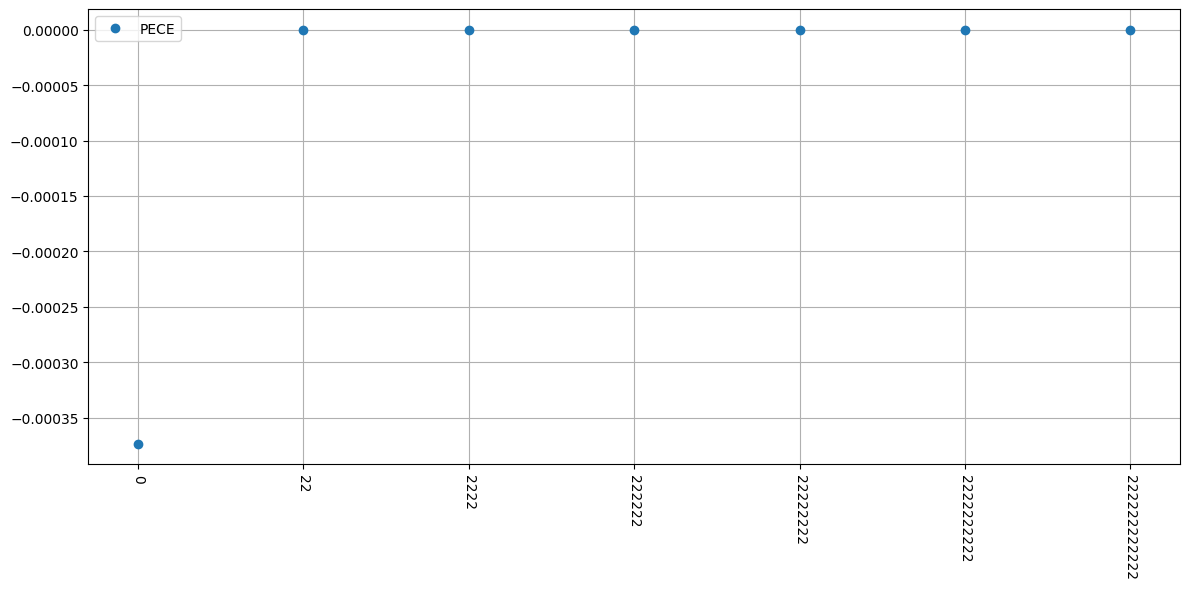

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=psi_T, nonzero=True, ax=ax, label="PECE")

ax.legend()
# ax.set_ylim([-0.75, 0.05])

### Dependence on the truncation order

In [81]:
truncs = [4, 6, 8, 10, 12]

shuffle_tables = [ta.get_shuffle_table(table_trunc=trunc, dim=dim) for trunc in truncs]

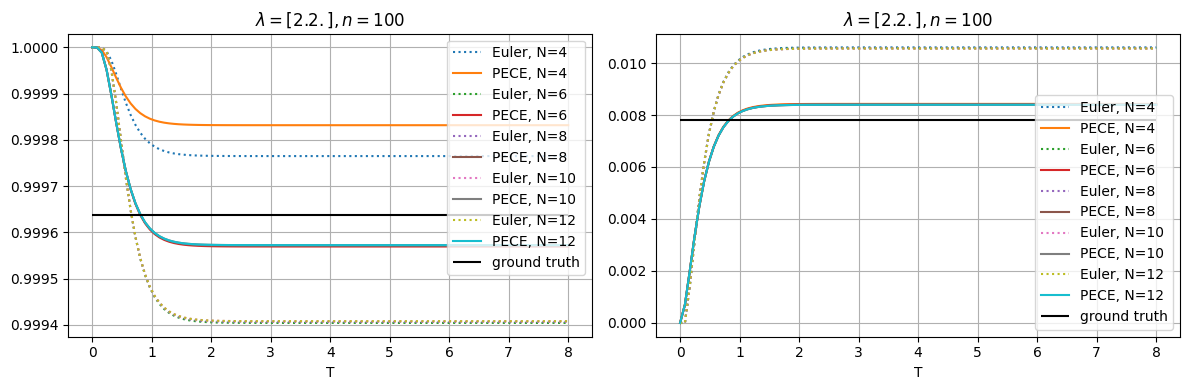

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

T = 8
n = 100
t_grid_trunc = np.linspace(0, T, n)

for trunc, shuffle_table_trunc in zip(truncs, shuffle_tables):
    u_trunc = ta.from_array(u.array, trunc=trunc, dim=dim)
    args_trunc = {"shuffle_table": shuffle_table_trunc, "lam": lam}
    
    psi_euler = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_euler, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    #psi_rk = ode_solver_traj(fun=ode_fun, step_fun=step_fun_rk4, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    psi_pece = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_pece, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    
    ax[0].plot(t_grid_trunc, np.exp(psi_euler[0]).real, ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax[0].plot(t_grid_trunc, np.exp(psi_pece[0]).real, "-", label=f"PECE, N={trunc}")

    ax[1].plot(t_grid_trunc, np.exp(psi_euler[0]).imag, ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax[1].plot(t_grid_trunc, np.exp(psi_pece[0]).imag, "-", label=f"PECE, N={trunc}")

ax[0].hlines(sample.mean().real, t_grid_trunc[0], t_grid_trunc[-1], color="k", label="ground truth")
ax[0].set_xlabel("T")
#ax[0].set_ylim([0.98, 1.01])
ax[0].set_title(f"$\lambda = {lam}, n = {n}$")
ax[0].legend()

ax[1].hlines(sample.mean().imag, t_grid_trunc[0], t_grid_trunc[-1], color="k", label="ground truth")
ax[1].set_xlabel("T")
#ax[1].set_ylim([0., .1])
ax[1].set_title(f"$\lambda = {lam}, n = {n}$")
ax[1].legend()

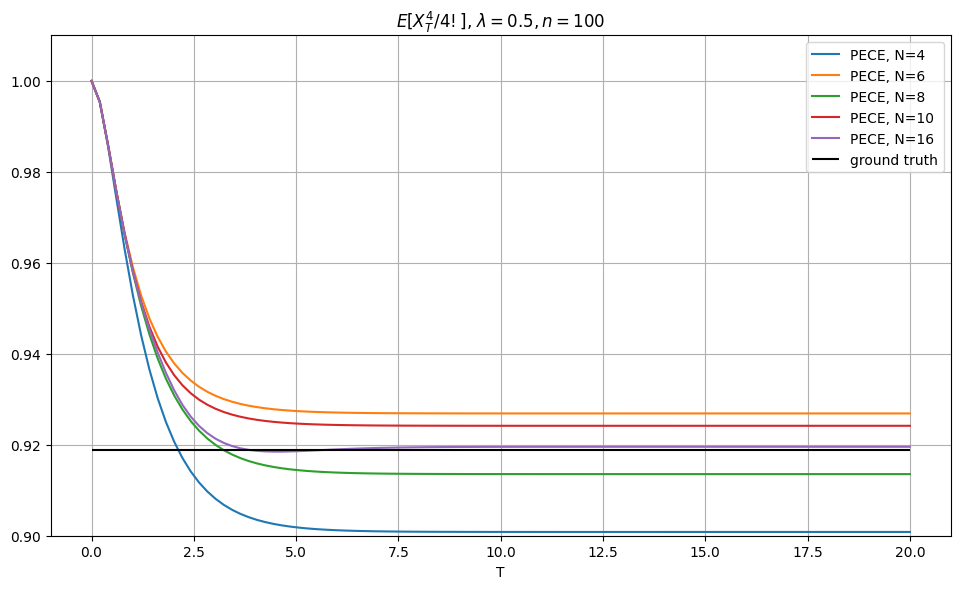

In [299]:
fig, ax = plt.subplots()

for trunc in [4, 6, 8, 10, 16]:
    T = 20
    n = 100
    u_coef = -1
    t_grid = np.linspace(0, T, n)
    lam = 0.5
    
    u = ta.from_word("2222", trunc=trunc) * u_coef
    
    psi_euler, psi_0_euler = psi_riccati_euler_stat(t_grid=t_grid, u=u, lam=lam)
    psi_pece, psi_0_pece = psi_riccati_pece_stat(t_grid=t_grid, u=u, lam=lam)
    
    # ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_pece), "-", label=f"PECE, N={trunc}")
        
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam)**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))

ax.hlines(cf_quad, t_grid[0], t_grid[-1], color="k", label="ground truth")
ax.set_xlabel("T")
ax.set_ylim([0.9, 1.01])
ax.set_title("$E[{X_T^4}/{4!}]$" + f", $\lambda = {lam}, n = {n}$")
ax.legend()

# III. Signature characteristic function in 1D

In [5]:
N = 19
dim = 1
e = ta.AlgebraBasis(dim=dim, trunc=N)

In [21]:
T = 5
u_coef = -1j

#### Via MC

In [22]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(u_coef * W_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

((0.611216381265745-0.18220627787897453j), 0.0007702047828817322)

#### Via quadratures

In [23]:
N_points = 160
z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * T**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]

(0.5664158555676426-0.11476424648543442j)

#### Via inf-dimensional Riccati

In [24]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)

args = {"shuffle_table": shuffle_table}

In [25]:
u = ta.from_word(1111, trunc=10, dim=1) * u_coef
print(ta.shuffle_pow(u, 2, shuffle_table))

-70.0*11111111


In [26]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [27]:
n = 200
t_grid = np.linspace(0, T, n)

Euler : (0.5493539755817922-0.10309423695415874j)


C:\Users\DM6579\OneDrive - ENGIE\projects\signature\signature\visualisation.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients[plotting_idx], "o", **kwargs)


RK4 : (0.5525746843764101-0.09681923545110223j)


C:\Users\DM6579\OneDrive - ENGIE\projects\signature\signature\visualisation.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients[plotting_idx], "o", **kwargs)


KeyboardInterrupt: 

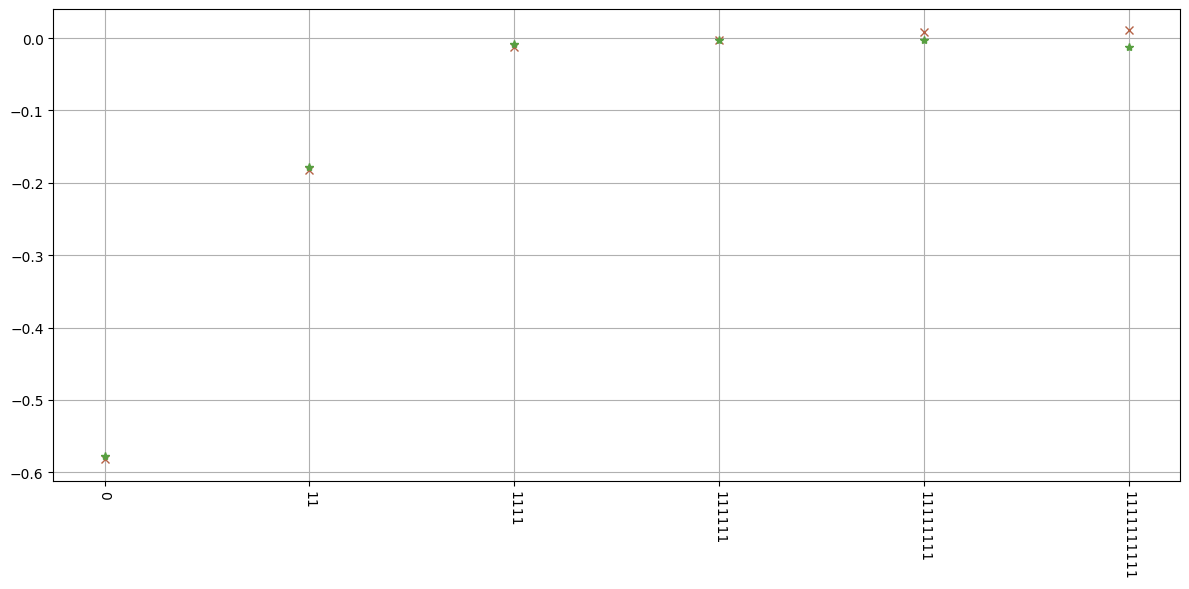

In [28]:
labels = ["Euler", "RK4", "PECE"]
markers = ["x", "*", "v"]
step_funs = [step_fun_euler, step_fun_rk4, step_fun_pece]
fig, ax = plt.subplots(figsize=(12, 6))

for label, step_fun, marker in zip(labels, step_funs, markers):
    psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u, args=args)
    psi_T = psi.subsequence([-1,])
    print(label, ":", np.exp(psi_T[0]))
    ta.plot_coefficients(psi_T, nonzero=True, ax=ax, marker=marker, label=label)

ax.legend()

### Dependence on the truncation order

In [20]:
truncs = [4, 6, 8, 10, 12]

shuffle_tables = [ta.get_shuffle_table(table_trunc=trunc, dim=dim) for trunc in truncs]

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\DM6579\AppData\Local\Temp\ipykernel_11376\649671163.py:17: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid_trunc, np.exp(psi_pece[0]), "-", label=f"PECE, N={trunc}")
C:\Users\DM6579\

KeyboardInterrupt: 

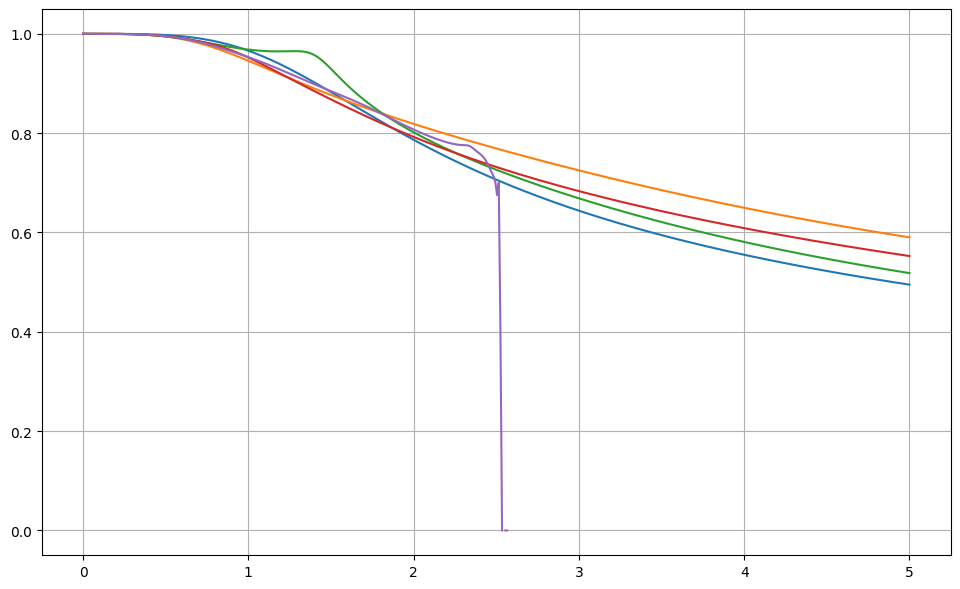

In [21]:
fig, ax = plt.subplots()

T = 5
n = 500
t_grid_trunc = np.linspace(0, T, n)

for trunc, shuffle_table_trunc in zip(truncs, shuffle_tables):
    u_trunc = ta.from_array(u.array, trunc=trunc, dim=dim)
    args_trunc = {"shuffle_table": shuffle_table_trunc}
    
    #psi_euler = ode_solver_traj(fun=ode_fun, step_fun=step_fun_euler, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    #psi_rk = ode_solver_traj(fun=ode_fun, step_fun=step_fun_rk4, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    psi_pece = ode_solver_traj(fun=ode_fun, step_fun=step_fun_pece, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    
    #ax.plot(t_grid_trunc, np.exp(psi_euler[0]), ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax.plot(t_grid_trunc, np.exp(psi_pece[0]), "-", label=f"PECE, N={trunc}")

rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample)[:, None] * np.sqrt(t_grid_trunc)[None, :]
sample = np.exp(u_coef * W_T**4 / 24)

ax.plot(t_grid_trunc, sample.mean(axis=0), "-k", label="MC")
ax.set_xlabel("T")
ax.set_ylim([0., 1.05])
ax.legend()

## FM-signature characteristic function

In [111]:
lam = 1 * jnp.ones(1)

#### Via MC

In [112]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
X_T = rng.normal(size=n_sample) * np.sqrt(1 / (2 * lam[0]))
sample = np.exp(u_coef * X_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

((0.9949432675891916+0.02977894674921571j), 9.592240931841409e-05)

#### Via quadratures

In [113]:
from scipy.special import roots_laguerre


N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam[0])**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad

(0.9949993855510688+0.029701480587887734j)

In [114]:
ta.index_to_word(index=19, dim=1)

Array(1111111111111111111, dtype=int64)

In [115]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)

args = {"shuffle_table": shuffle_table, "lam": lam}

In [175]:
T = 5
n = 200
t_grid = np.linspace(0, T, n)

In [176]:
psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_pece, t_grid=t_grid, init=u, args=args)

In [177]:
psi_T = psi.subsequence([-1,])
print(np.exp(psi_T[0]))

(0.9949593787201184+0.02976391065469061j)


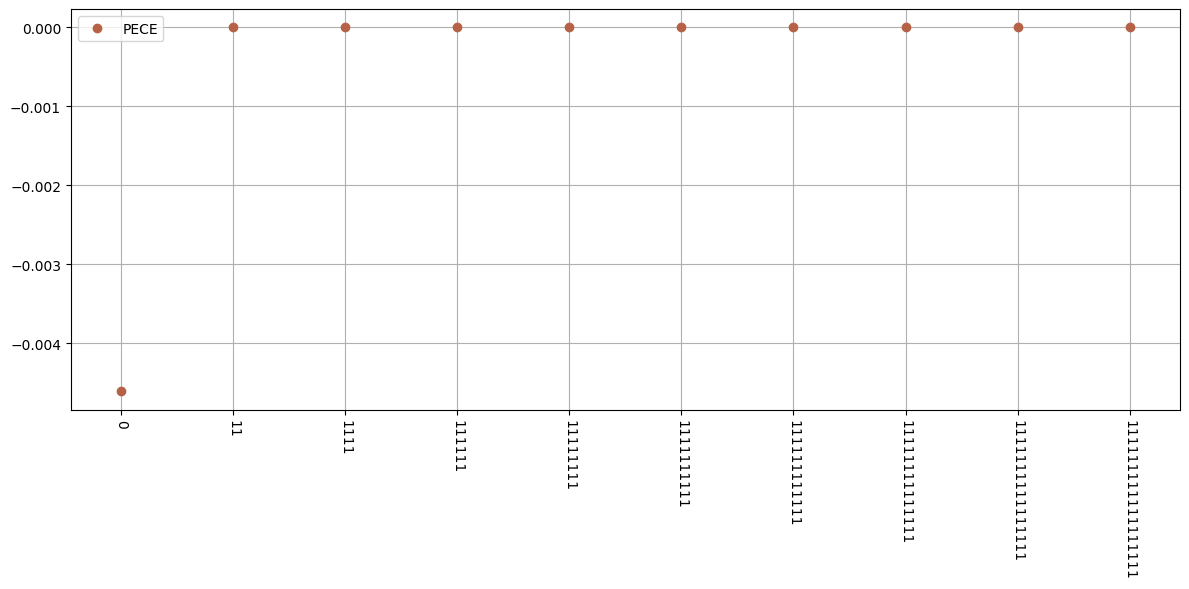

In [179]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=psi_T, nonzero=True, ax=ax, label="PECE")

ax.legend()
# ax.set_ylim([-0.75, 0.05])

### Dependence on the truncation order

In [173]:
truncs = [6, 9, 12, 15]

shuffle_tables = [ta.get_shuffle_table(table_trunc=trunc, dim=dim) for trunc in truncs]

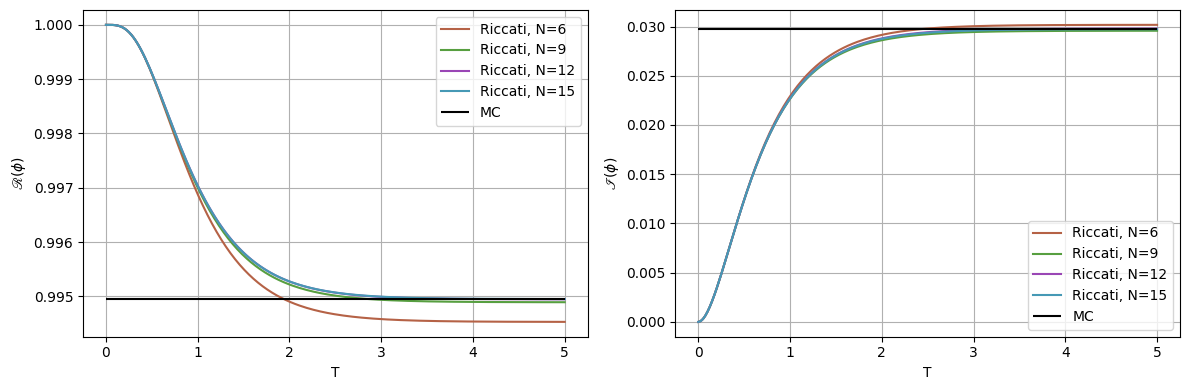

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

T = 5
n = 200
t_grid_trunc = np.linspace(0, T, n)

for trunc, shuffle_table_trunc in zip(truncs, shuffle_tables):
    u_trunc = ta.from_array(u.array, trunc=trunc, dim=dim)
    args_trunc = {"shuffle_table": shuffle_table_trunc, "lam": lam}
    
    #psi_euler = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_euler, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    #psi_rk = ode_solver_traj(fun=ode_fun, step_fun=step_fun_rk4, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    psi_pece = ode_solver_traj(fun=ode_fun, step_fun=step_fun_semi_int_pece, t_grid=t_grid_trunc, init=u_trunc, args=args_trunc)
    
    #ax[0].plot(t_grid_trunc, np.exp(psi_euler[0]).real, ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax[0].plot(t_grid_trunc, np.exp(psi_pece[0]).real, "-", label=f"Riccati, N={trunc}")

    #ax[1].plot(t_grid_trunc, np.exp(psi_euler[0]).imag, ":", label=f"Euler, N={trunc}")
    #ax.plot(t_grid_trunc, np.exp(psi_rk[0]), "--", label=f"RK, N={trunc}")
    ax[1].plot(t_grid_trunc, np.exp(psi_pece[0]).imag, "-", label=f"Riccati, N={trunc}")

ax[0].hlines(sample.mean().real, t_grid_trunc[0], t_grid_trunc[-1], color="k", label="MC")
# ax[0].hlines(cf_quad.real, t_grid_trunc[0], t_grid_trunc[-1], color="g", label="ground truth (CF)")
ax[0].set_xlabel("T")
ax[0].set_ylabel(r"$\mathscr{R}(\phi)$")
#ax[0].set_ylim([0.98, 1.01])
#ax[0].set_title(f"$\lambda = {lam[0]}, n = {n}$")
ax[0].legend()

ax[1].hlines(sample.mean().imag, t_grid_trunc[0], t_grid_trunc[-1], color="k", label="MC")
# ax[1].hlines(cf_quad.imag, t_grid_trunc[0], t_grid_trunc[-1], color="g", label="ground truth (CF)")
ax[1].set_xlabel("T")
ax[1].set_ylabel(r"$\mathscr{I}(\phi)$")

#ax[1].set_ylim([0., .1])
#ax[1].set_title(f"$\lambda = {lam[0]}, n = {n}$")
ax[1].legend()

plt.savefig("CF_plots.pdf", format="pdf", transparent=True)

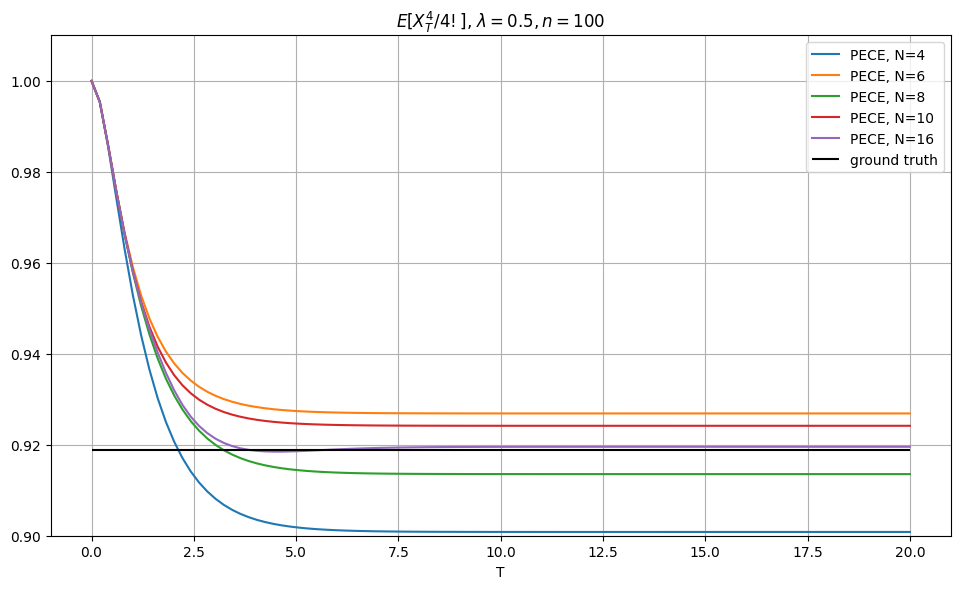

In [299]:
fig, ax = plt.subplots()

for trunc in [4, 6, 8, 10, 16]:
    T = 20
    n = 100
    u_coef = -1
    t_grid = np.linspace(0, T, n)
    lam = 0.5
    
    u = ta.from_word("2222", trunc=trunc) * u_coef
    
    psi_euler, psi_0_euler = psi_riccati_euler_stat(t_grid=t_grid, u=u, lam=lam)
    psi_pece, psi_0_pece = psi_riccati_pece_stat(t_grid=t_grid, u=u, lam=lam)
    
    # ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_pece), "-", label=f"PECE, N={trunc}")
        
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam)**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))

ax.hlines(cf_quad, t_grid[0], t_grid[-1], color="k", label="ground truth")
ax.set_xlabel("T")
ax.set_ylim([0.9, 1.01])
ax.set_title("$E[{X_T^4}/{4!}]$" + f", $\lambda = {lam}, n = {n}$")
ax.legend()